In [1]:
import numpy as np
import scipy
import pandas as pd

import copy

import random

from sklearn.model_selection import train_test_split

import keras
from keras.layers import Activation
from keras import backend as K
keras.backend.set_floatx('float64')
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

## definitions and dimensions

In [2]:
spot = 1.0

model_stoch = 'rHeston'
fwdvar = 'pwc'

N_params_fvc = 8
N_params_mdl = 3

N_params = N_params_fvc + N_params_mdl

N_times      = 11
N_strikes    = 13

N_ivols = N_times*N_strikes

## import/organize training data 

the entire dataset is available upon request. We provide both rHeston and/or rBergomi sample data with different specifications of the forward variance curve as explained in the text

the following code snippet performs necessary preprocessing of the input data (i.e. random grids) to a form that can be used in a pointwise approach

we share a simple .csv file for the reader to understand what the (final) data structure is like

## split data into train and test

In [3]:
N_params_TKinc = N_params + 1 + 1

## build the neural network

In [4]:
N_hiddenLayers = 4
N_nodes = 64
i = keras.layers.Input(shape=(N_params_TKinc, ))
x = keras.layers.Dense(N_nodes, activation='elu')(i)
c = 0
while c < N_hiddenLayers:
    x = keras.layers.Dense(N_nodes, activation='elu')(x)
    c += 1
x = keras.layers.Dense(1, activation='linear')(x)

model = keras.models.Model(inputs=i, outputs=x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense (Dense)               (None, 64)                896       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65    

## fit the model

In [5]:
N_epochs = 500
patience = 50
earlystop = EarlyStopping(monitor="val_loss",
                          min_delta=0,
                          mode="min",
                          verbose=1,
                          patience=patience)
 
def RMSE(y, y_hat):
    return K.sqrt(K.mean(K.square(y_hat - y)))

model.compile(loss = RMSE, optimizer = "adam")

no need to train (very slow) ...

## load optimal neural network weights 

... we provide the resulting neural network weights in a .h5 file

In [6]:
model.load_weights(model_stoch+'NNWeights_pntwise_'+fwdvar+'.h5')

NNWeights = []
for i in range(1, len(model.layers)):
    NNWeights.append(model.layers[i].get_weights())

## hardcode the neural network in numpy

In [7]:
N_layers = N_hiddenLayers + 1

def elu(x):
    ind = (x<0)
    x[ind] = np.exp(x[ind])-1
    return x

def eluPrime(x):
    y = np.copy(x)
    ind = (y<0)
    y[ind] = np.exp(y[ind])
    y[~ind] = 1
    return y

def NNFun(params, T, K):
    N = len(T)
    PARAMS = np.array(N*[params])
    input1 = np.c_[PARAMS, T, K]  
    for i in range(N_layers):
        input1 = np.dot(input1, NNWeights[i][0]) + NNWeights[i][1]
        input1 = elu(input1)
    i += 1
    X = np.dot(input1, NNWeights[i][0]) + NNWeights[i][1]
    X = [el[0] for el in X]
    X = np.array(X)
    return X

def NNGrad(params, T, K):
    N = len(T)
    PARAMS = np.array(N*[params])
    input1 = np.c_[PARAMS, T, K] 
    # k = 0
    input1 = np.dot(input1, NNWeights[0][0]) + NNWeights[0][1]
    grad = np.ndarray(shape=(N, N_params_TKinc, N_nodes))
    for j in range(N):
        grad[j] = NNWeights[0][0]
    eP = eluPrime(input1)
    grad *= eP[:, None, :]
    input1 = elu(input1)
    # 
    for k in range(1,N_layers):
        input1 = np.dot(input1, NNWeights[k][0])
        input1 += NNWeights[k][1]
        for n in range(N):
            grad[n] = np.dot(grad[n], NNWeights[k][0])
        eP = eluPrime(input1)
        grad *= eP[:, None, :]
        input1 = elu(input1)
    grad = np.einsum('Nij,jk->Nik', grad, NNWeights[k+1][0])
    grad = grad[:,:N_params].reshape(N, N_params).T
    return grad

## define the objective function and its gradient for calibration

In [8]:
def CostFunc(params, T, K, target):
    return (NNFun(params, T, K)-target)
def Jacobian(params, T, K):
    return NNGrad(params, T, K).T

### box constraints on the parameters and initial guess:

In [9]:
bounds = ([0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.010, 0.150, -.950], 
          [0.160, 0.160, 0.160, 0.160, 0.160, 0.160, 0.160, 0.160, 0.250, 0.650, -.500])
init = 0.5*(np.array(bounds[0])+np.array(bounds[1]))

## import/organize test data 

In [10]:
data_rnd_out = np.loadtxt(model_stoch+'_samples_'+fwdvar+'_rndGrid_outof.txt', dtype=float)

data_test = []
for row in data_rnd_out:
    params = [el for el in row[:N_params]]
    times = row[N_params:N_params+N_times]
    for i in range(N_times):
        strikes = row[N_params+N_times+i*N_strikes:N_params+N_times+(i+1)*N_strikes]
        ivols = row[N_params+N_times+N_ivols+i*N_strikes:N_params+N_times+N_ivols+(i+1)*N_strikes]
        for j in range(N_strikes):
            line = copy.deepcopy(params)
            line.append(times[i])
            line.append(strikes[j])
            line.append(ivols[j])
            data_test.append(line)
data_test = np.array(data_test)

In [11]:
idx = 0
volsurf = data_rnd_out[idx]
params_true = volsurf[:N_params]
maturities = volsurf[N_params:N_params+N_times]
T = []
for maturity in maturities:
    T.extend(N_strikes*[maturity])
K = volsurf[N_params+N_times:N_params+N_times+N_times*N_strikes]
v = volsurf[N_params+N_times+N_times*N_strikes:]
strikes = []
imp_vol = []
for i in range(N_times):
    strikes.append((K[i*N_strikes:(i+1)*N_strikes]).tolist())
    imp_vol.append((v[i*N_strikes:(i+1)*N_strikes]).tolist())
strikes = np.array(strikes)
imp_vol = np.array(imp_vol)

## calibrate to synthetic data in a controlled environment

In [12]:
res = scipy.optimize.least_squares(lambda x: CostFunc(x, T, K, v), init, 
                                   lambda x: Jacobian(x, T, K), bounds, gtol=1E-10)

optm_params = res.x
print('true params: ' + str(params_true))
print('optm params: ' + str(optm_params))
fval = res.fun
print('fval: ' + str(np.sum(fval**2)))

true params: [ 0.06972301  0.12028243  0.06719489  0.128636    0.05470923  0.12565392
  0.1363822   0.1063897   0.05683356  0.64331946 -0.51166094]
optm params: [ 0.06956525  0.11898724  0.06695247  0.1277246   0.05391543  0.12539366
  0.1362568   0.10498374  0.05361229  0.63907977 -0.51050947]
fval: 1.9963638756911627e-05


### check the quality of the reconstructed forward variance curve ...

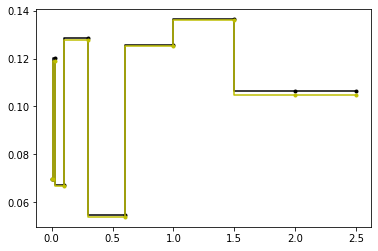

In [13]:
xi_tim = [0.0, 0.0100, 0.0250, 0.1000, 0.3000, 0.6000, 1.0000, 1.5000, 2.0000, 2.500]
xi_vec_true = np.array([el for lst in [[params_true[0]], params_true[:N_params_fvc], [params_true[N_params_fvc-1]]] for el in lst])
xi_vec_optm = np.array([el for lst in [[optm_params[0]], optm_params[:N_params_fvc], [optm_params[N_params_fvc-1]]] for el in lst])
plt.step(xi_tim, xi_vec_true, 'k.-', where='pre')
plt.step(xi_tim, xi_vec_optm, 'y.-', where='pre')
plt.show()

### ... and the fits to the market

In [14]:
NNvols = NNFun(optm_params, T, K)

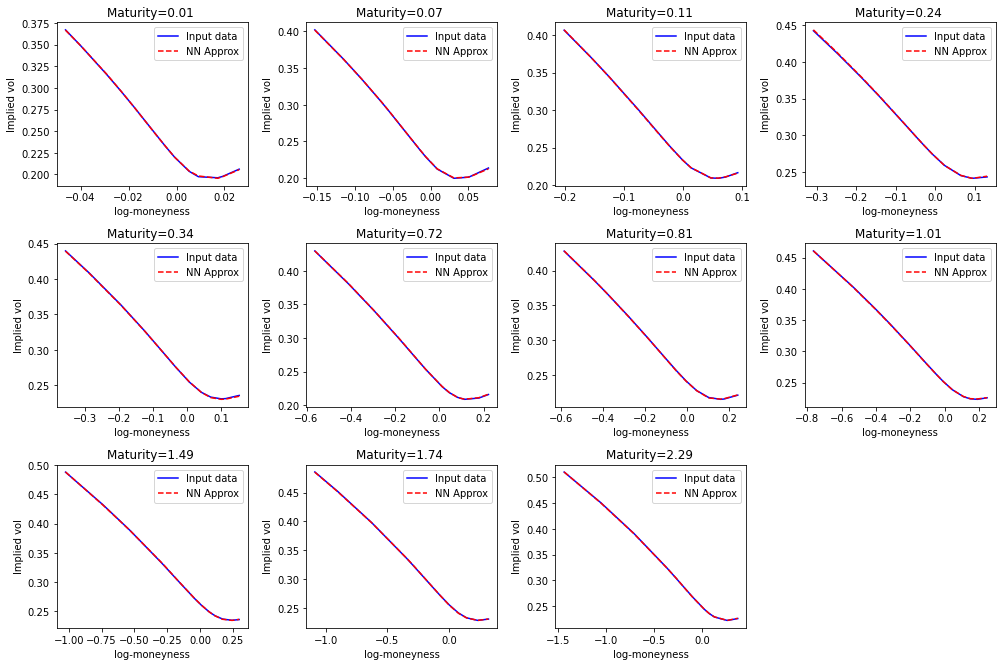

In [15]:
plt.figure(1, figsize=(14,12))
for i in range(N_times):
    plt.subplot(4, 4, i+1)
    
    plt.plot(np.log(strikes[i]/spot), v[i*N_strikes:(i+1)*N_strikes], 'b'  , label="Input data")
    plt.plot(np.log(strikes[i]/spot), NNvols[i*N_strikes:(i+1)*N_strikes], '--r', label="NN Approx" )
        
    plt.title("Maturity=%1.2f "%np.unique(maturities[i]))
    plt.xlabel("log-moneyness")
    plt.ylabel("Implied vol")
    
    plt.legend()
plt.tight_layout()
plt.show()